### 1) A Cayley tree is a symmetric tree, constructed starting from a central node of degree k. Each node at distance d from the central node has degree k, until we reach the nodes at distance P that have degree one and are called leaves.

#### 1. Calculate the number of nodes reachable in t steps from the central node.

 $N = 1 + k^t$ for $t \leq P$

#### 2. Calculate the degree distribution of the network.

 $P_k = \frac{k-1}{k}$

#### 3. Calculate the diameter $d_{max}$.

 $d_{max} = 2P$

#### 4. Find an expression for the diameter $d_{max}$ in terms of the number of nodes N.

 $d_{max} = N$

#### 5. Does the network display the small-world property?

 No, because its gamma in the equation $P_k = Ck^{-\gamma}$ will be less than two which is a satisfation for the small-world phenomena

### 2) Before you try to solve the following problem, please read Section 5.13 from A.L.Barabasi’s textbook to understand the rate-equation approach. After you do so, consider a variation of the preferential attachment model, where at each time step a new node arrives and connects with a directed edge to a node chosen with probability:

$ \prod(k_i^{in}) = \frac{k_i^{in} + A}{\sum_j(k_j^{in} + A)} $

### Here, $k_i$ in indicates the in-degree of node i and A is the same constant for all nodes. Each new node has m directed edges. Calculate, using the rate equation approach, the in- and out-degree distribution of the resulting network.

$\prod(k_i^{in}) = \frac{k_i^{in} + A}{\sum_j(k_j^{in} + A)} = \frac{k_i^{in} + A}{2mt + A}$

$P_{k_i^{in}} = \frac{2m(m+1)}{k_i^{in}(k_i^{in}+1)(k_i^{in}+2)}$

### 3-1) Write a function (ideally in Python – but you can also use any other language) that generates an undirected growing network based on the K Nearest-Neighbors (KNN) rule, as follows:

### –Start with a clique of n0 nodes that are randomly located in the Cartesian square S=[0,1]×[0,1].

### –Grow the network by adding one node in each iteration.  The new node must be located at a randomly chosen location within S,  and it should be connected to its K nearest neighbors.

### Use G=KNN model (n0, K, N) as the interface of your function, where N is the number of iterations and G is the final network.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.optimize import curve_fit
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def make_xy_clique_add_nodes_iter(n0, K, N):
    """
    Makes a clique of n0 nodes, iteratively adds N number of nodes 1 at a time, and connects them to their
    K-nearest neighbors. All nodes are added randomly in the xy-plane ranging from 0 to 1.
    """
    
    # Make the clique of n0 nodes
    graph = nx.complete_graph(n0)
    num_nodes = nx.number_of_nodes(graph)
    for node_num in range(num_nodes):
        graph.node[node_num]['x'] = np.random.random_sample()
        graph.node[node_num]['y'] = np.random.random_sample()
        node_num +=1
        
    # Initialize a list of xy coordinates of the nodes, this will be updated as new nodes are added
    x_coord = list(nx.get_node_attributes(graph,'x').values())
    y_coord = list(nx.get_node_attributes(graph,'y').values())
    xy_coords = []
    for x,y in zip(x_coord, y_coord): 
        xy_coords.append([x, y])
    
    # Adds the new nodes 1 at a time, adds thie coords to xy_coords list, 
    # and connects them to their K-nearest neighbors
    # If K is larger than the number of nodes in graph, then new node is connected to all nodes
    new_node_num = n0 + N
    for node_num in range(n0, new_node_num):
        graph.add_node(node_num)
        graph.node[node_num]['x'] = np.random.random_sample()
        graph.node[node_num]['y'] = np.random.random_sample()
        xy_coords.append([graph.node[node_num]['x'], graph.node[node_num]['y']])
        if node_num < K: 
            num_nbrs = node_num    
        else: 
            num_nbrs = K
        nbrs = NearestNeighbors(n_neighbors=num_nbrs+1).fit(xy_coords)
        distances, indices = nbrs.kneighbors(xy_coords)
        for nbr in range(1, num_nbrs+1):
            nrst_nbr = indices[node_num][nbr]
            graph.add_edge(node_num, nrst_nbr)
    
    return graph

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 8.53 ms


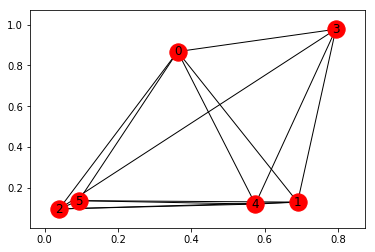

In [3]:
# Test the function
%time example = make_xy_clique_add_nodes_iter(3,4,3)
xy_coords = []
for x,y in zip(
               list(nx.get_node_attributes(example,'x').values()), 
               list(nx.get_node_attributes(example,'y').values())
               ): 
    xy_coords.append([x, y])
nx.draw_networkx(example, xy_coords)

Figure 1-1) Example graph to show that the function does what it is designed to do.

### 3-2) Using your KNN model function, construct networks with N=10000, n0=4 and K=4. Does this model generate scale-free networks?  Does it generate small-world networks?  Justify your answer with the appropriate graphs.

In [4]:
%time prob2 = make_xy_clique_add_nodes_iter(4,4,10000)

CPU times: user 2min 22s, sys: 52 ms, total: 2min 22s
Wall time: 2min 22s


In [5]:
prob2_degree = prob2.degree()
prob2_degree_count = Counter(prob2_degree.values())

In [6]:
k = list(prob2_degree_count.keys())
N = list(prob2_degree_count.values())
Pk = [x / 10000. for x in prob2_degree_count.values()]

In [7]:
def func_powerlaw(k, C, gamma):
    return C * (k**(-gamma))

In [8]:
popt, pcov = curve_fit(func_powerlaw, k, Pk)
print("C = ", popt[0],
      "\nGamma = ", popt[1],"\n")
print("Variance of C = ", pcov[0][0],
      "\nCovariance of C and Gamma = ", pcov[0][1], 
      "\nVariance of Gamma = ", pcov[1][1])

C =  2.1929560114 
Gamma =  1.6699607665 

Variance of C =  0.0827008341588 
Covariance of C and Gamma =  0.0211800780804 
Variance of Gamma =  0.00571827252429


[0, 100, 1e-05, 0.225]

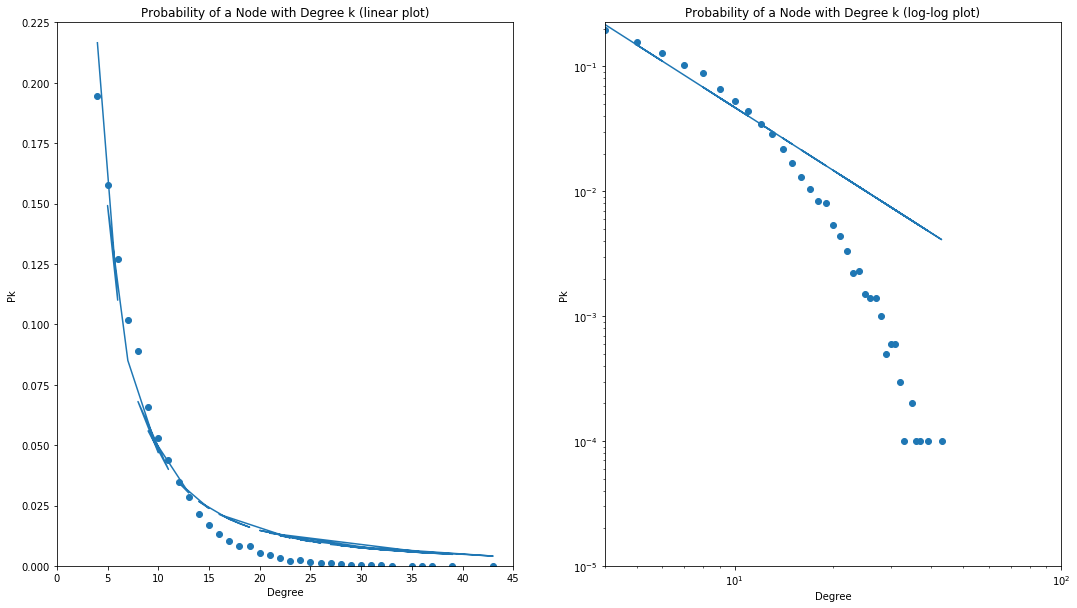

In [9]:
plt.figure(figsize=(18, 10))

plt.subplot(121)
plt.scatter(k, Pk)
plt.title('Probability of a Node with Degree k (linear plot)')
plt.xlabel('Degree')
plt.ylabel('Pk')
plt.plot(k, func_powerlaw(k, popt[0], popt[1]))
plt.axis([0, 45, 0, 0.225])

plt.subplot(122)
plt.scatter(k, Pk)
plt.title('Probability of a Node with Degree k (log-log plot)')
plt.xlabel('Degree')
plt.ylabel('Pk')
plt.xscale('log')
plt.yscale('log')
plt.plot(k, func_powerlaw(k, popt[0], popt[1]), label='fit')
plt.axis([0, 100, 1e-05, 2.25e-01])

Figure 2-1) The distribution of the degree k of the nodes generated from the G=KNN model where n0=1000, K=4, and N=4).

In Figure 2-1, the plot on the left is a linear plot of Degree (k) vs. Probability of Node Degree k, its shows an exponential decay. The plot in the top-right is a log-log plot of Degree (k) vs. Probability of Node Degree k, its nodes follow a decreasing linear trend; this looks a lot like a power law meaning this data <b>is a scale-free network</b>. A random network would have a Poisson distribution; a hump would be located in the middle of the degree distribution in the plot in the top-left.

**My curve fit is wrong** Fitting my data to the power law $Pk = Ck^{-\gamma}$, results in gamma being equal to 1.68. This does not make sense, we expect $2<\gamma$ since large graphs often have small-world phenomena and to have this phenomena, $2<\gamma$. The curve I have fit here does not match the data very well, it's obvious to see how the curve did not fit the plot on the left correctly. In the right plot, I expected the line to have a steeper decline; this lines slope is proportional to $\gamma$ which I already pointed out was greater than expected. Even giving the function bounds and expected values did not result in a well-fitting curve. Visually fitting my function to the plot, you can see that gamma would have been lower, perhaps between 2 and 3 as expected.

### 3-3) Tweak the previous KNN model such that for every new node, half of its edges are placed based on the nearest-neighbors rule, while the other half are placed based on the random “link-selection” model, described in class and in Section 5.9.2 of Barabasi’s book. How does the resulting degree distribution of this model relate to the degree distribution of the original model? (include relevant graphs)

In [10]:
def make_xy_clique_add_nodes_iter_half_random(n0, K, N):
    """
    Same as function above, except when a new node is added, half of its edges are added to its nearest neighbor,
    while the other half are added randomly.
    """
    
    # Make the clique of n0 nodes
    graph = nx.complete_graph(n0)
    num_nodes = nx.number_of_nodes(graph)
    for node_num in range(num_nodes):
        graph.node[node_num]['x'] = np.random.random_sample()
        graph.node[node_num]['y'] = np.random.random_sample()
        node_num +=1
        
    # Initialize a list of xy coordinates of the nodes, this will be updated as new nodes are added
    x_coord = list(nx.get_node_attributes(graph,'x').values())
    y_coord = list(nx.get_node_attributes(graph,'y').values())
    xy_coords = []
    for x,y in zip(x_coord, y_coord): 
        xy_coords.append([x, y])
    
    # Adds the new nodes 1 at a time, adds thie coords to xy_coords list, 
    # and connects them to their K-nearest neighbors
    # If K is larger than the number of nodes in graph, then new node is connected to all nodes
    new_node_num = n0 + N
    for node_num in range(n0, new_node_num):
        graph.add_node(node_num)
        graph.node[node_num]['x'] = np.random.random_sample()
        graph.node[node_num]['y'] = np.random.random_sample()
        xy_coords.append([graph.node[node_num]['x'], graph.node[node_num]['y']])
        
        if node_num < K: 
            num_nbrs = node_num    
        else: 
            num_nbrs = K
        nbrs = NearestNeighbors(n_neighbors=num_nbrs+1).fit(xy_coords)
        distances, indices = nbrs.kneighbors(xy_coords)
        
        random_int = random.randint(0, num_nbrs)

        for nbr in range(1, num_nbrs+1-random_int):
            nrst_nbr = indices[node_num][nbr]
            graph.add_edge(node_num, nrst_nbr)
            
        nodes_tried = []
        while random_int > 0:
            random_edge = random.choice(graph.edges())
            if graph.has_edge(node_num, random_edge[0]) and random_edge[0] not in nodes_tried:
                nodes_tried.append(random_edge[0])
            elif graph.has_edge(node_num, random_edge[0]) and random_edge[0] in nodes_tried:
                continue
            elif not graph.has_edge(node_num, random_edge[0]):
                graph.add_edge(node_num, random_edge[0])
                nodes_tried.append(random_edge[0])
                random_int-=1
            else:
                random_int-=1  
    
    return graph

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.63 ms


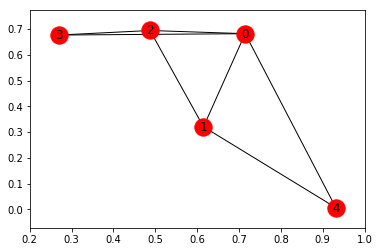

In [11]:
# Test the function
%time example2 = make_xy_clique_add_nodes_iter_half_random(3,2,2)
xy_coords = []
for x,y in zip(
               list(nx.get_node_attributes(example2,'x').values()), 
               list(nx.get_node_attributes(example2,'y').values())
               ): 
    xy_coords.append([x, y])
nx.draw_networkx(example2, xy_coords)

Figure 3-1) Example graph to show that the function does what it is designed to do.

In [12]:
%time prob3 = make_xy_clique_add_nodes_iter_half_random(4,4,10000)

CPU times: user 5min 38s, sys: 52 ms, total: 5min 38s
Wall time: 5min 38s


In [13]:
prob3_degree = prob3.degree()
prob3_degree_count = Counter(prob3_degree.values())
k = list(prob3_degree_count.keys())
N = list(prob3_degree_count.values())
Pk = [x / 10000. for x in prob3_degree_count.values()]

In [14]:
# This curve fit the data even worse than in Problem 2-2, so I omitted it
popt, pcov = curve_fit(func_powerlaw, k, Pk)
print("C = ", popt[0],
      "\nGamma = ", popt[1],"\n")
print("Variance of C = ", pcov[0][0],
      "\nCovariance of C and Gamma = ", pcov[0][1], 
      "\nVariance of Gamma = ", pcov[1][1])

C =  11.2176730176 
Gamma =  2.54466767851 

Variance of C =  0.0367215773104 
Covariance of C and Gamma =  0.00209665492683 
Variance of Gamma =  0.000122494719451


[0, 350, 1e-05, 0.225]

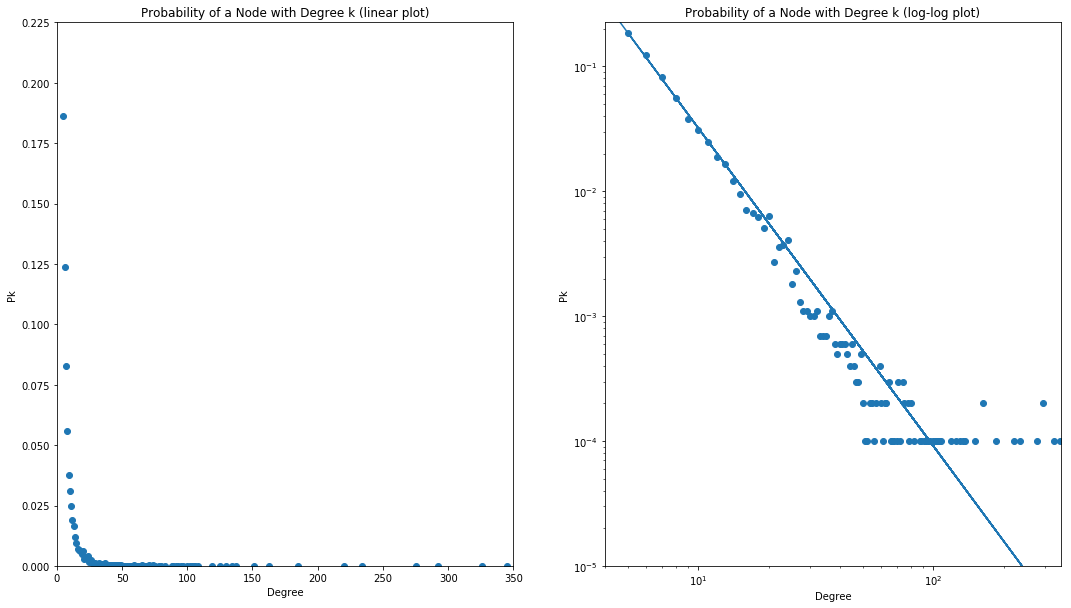

In [27]:
plt.figure(figsize=(18, 10))

plt.subplot(121)
plt.scatter(k, Pk)
plt.title('Probability of a Node with Degree k (linear plot)')
plt.xlabel('Degree')
plt.ylabel('Pk')
#plt.plot(k, func_powerlaw(k, popt[0], popt[1]))
plt.axis([0, 350, 0, 0.225])

plt.subplot(122)
plt.scatter(k, Pk)
plt.title('Probability of a Node with Degree k (log-log plot)')
plt.xlabel('Degree')
plt.ylabel('Pk')
plt.xscale('log')
plt.yscale('log')
plt.plot(k, func_powerlaw(k, popt[0], popt[1]), label='fit')
plt.axis([0, 350, 1e-05, 2.25e-01])

Figure 3-1) The distribution of the degree k of the nodes generated from the G=KNN model where n0=1000, K=4, and N=4) and half the edges are added randomly by picking edges.

Even though the curve looks like it fit the data in the log-log plot very well, it did not. I left out the curve on the plot on the left because it was terrible. I clearly did not learn how to fit curves very well using scipy. The data looks similar to that in Problem 3-2, except that the maximum k-value has increased substaintially from 42 to 345, and the data in the log-log plot is not sublinear like in Problem 3-2, but linear preferential attachment which means this data is a great example of a scale-free network. Even though my curve does not mean much, the $\gamma$ extracted from it is reasonable with a value of 2.55.